#Predicting covid cases in India based on mobility in different areas using Decision Trees and Random Forest from scratch

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.model_selection import GridSearchCV

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
daf1=pd.read_csv('/content/drive/MyDrive/covid-data.csv')
daf1.head()

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index
0,AFG,Asia,Afghanistan,2020-02-24,1.0,1.0,NaN,NaN,NaN,NaN,...,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511
1,AFG,Asia,Afghanistan,2020-02-25,1.0,0.0,NaN,NaN,NaN,NaN,...,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511
2,AFG,Asia,Afghanistan,2020-02-26,1.0,0.0,NaN,NaN,NaN,NaN,...,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511
3,AFG,Asia,Afghanistan,2020-02-27,1.0,0.0,NaN,NaN,NaN,NaN,...,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511
4,AFG,Asia,Afghanistan,2020-02-28,1.0,0.0,NaN,NaN,NaN,NaN,...,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511


In [6]:
#Extracting columns of interest
df1 = daf1.loc[:, ['iso_code','continent','location','date','new_cases']]

In [7]:
daf2=pd.read_csv('/content/drive/MyDrive/changes-visitors-covid_final.csv')
daf2.head(10)

,Entity,Code,Day,retail_and_recreation,grocery_and_pharmacy,residential,transit_stations,parks,workplaces
0,Afghanistan,AFG,2020-02-17,0.000,4.000,1.333,5.667,1.000,-6.333
1,Afghanistan,AFG,2020-02-18,0.750,4.250,0.750,6.500,1.500,-3.250
2,Afghanistan,AFG,2020-02-19,0.400,4.000,0.800,5.200,1.400,-1.600
3,Afghanistan,AFG,2020-02-20,0.000,3.833,0.833,5.000,1.000,-0.333
4,Afghanistan,AFG,2020-02-21,0.000,4.571,0.714,5.286,1.429,0.571
5,Afghanistan,AFG,2020-02-22,1.571,6.714,0.000,6.571,2.286,5.429
6,Afghanistan,AFG,2020-02-23,1.429,6.000,0.143,6.143,2.429,5.714
7,Afghanistan,AFG,2020-02-24,1.000,6.286,0.286,6.143,2.714,6.000
8,Afghanistan,AFG,2020-02-25,0.857,6.286,0.429,6.143,2.429,6.143
9,Afghanistan,AFG,2020-02-26,0.857,6.571,0.429,6.571,2.571,6.143


In [8]:
#Extracting columns of interest
df2 = daf2.loc[:, ['Entity','Code','Day','retail_and_recreation','grocery_and_pharmacy','residential','transit_stations','parks','workplaces']]

For this project, we are only going to take India in consideration

In [9]:
ind_names = df1[ df1['location'].str.lower() != "india" ].index
df1.drop(ind_names, inplace = True)
df1.head()

,iso_code,continent,location,date,new_cases
38584,IND,Asia,India,2020-01-30,1.0
38585,IND,Asia,India,2020-01-31,0.0
38586,IND,Asia,India,2020-02-01,0.0
38587,IND,Asia,India,2020-02-02,1.0
38588,IND,Asia,India,2020-02-03,1.0


In [10]:
df1.shape

(491, 5)

In [11]:
ind_names1 = df2[ df2['Entity'].str.lower() != "india" ].index
df2.drop(ind_names1, inplace = True)
df2.head()

,Entity,Code,Day,retail_and_recreation,grocery_and_pharmacy,residential,transit_stations,parks,workplaces
23897,India,IND,2020-02-17,0.667,1.667,0.000,2.000,3.000,3.000
23898,India,IND,2020-02-18,0.500,1.750,0.000,2.000,3.250,3.000
23899,India,IND,2020-02-19,0.400,1.800,0.200,1.800,2.800,3.200
23900,India,IND,2020-02-20,0.500,2.000,0.000,2.333,3.167,3.333
23901,India,IND,2020-02-21,-0.143,1.714,0.714,1.429,3.571,0.143


In [12]:
df2.shape

(471, 9)

In [13]:
#Renaming "day" column of df2 dataframe as "date" to help merge with df1 dataframe on a common column
df2.rename(columns = {'Day':'date'}, inplace = True)

#Data cleaning and preprocessing

In [14]:
#By observing that the dataframe df1 has 20 extra rows(491-471) having 20 extra days
#After merging df1 and df2 the 20 extra rows having crucial missing data from df2 is removed
df3 = pd.merge(df1, df2, on ='date')
df3.head()

,iso_code,continent,location,date,new_cases,Entity,Code,retail_and_recreation,grocery_and_pharmacy,residential,transit_stations,parks,workplaces
0,IND,Asia,India,2020-02-17,0.0,India,IND,0.667,1.667,0.000,2.000,3.000,3.000
1,IND,Asia,India,2020-02-18,0.0,India,IND,0.500,1.750,0.000,2.000,3.250,3.000
2,IND,Asia,India,2020-02-19,0.0,India,IND,0.400,1.800,0.200,1.800,2.800,3.200
3,IND,Asia,India,2020-02-20,0.0,India,IND,0.500,2.000,0.000,2.333,3.167,3.333
4,IND,Asia,India,2020-02-21,0.0,India,IND,-0.143,1.714,0.714,1.429,3.571,0.143


In [15]:
df3.shape

(471, 13)

In [16]:
#Checking if the column values of "isocode" from df1 and "Code" from df2 are the same
ind_names2 = df3[ df3['iso_code'].str.lower() != df3['Code'].str.lower()].index
df3.drop(ind_names2, inplace = True)
df3.shape

(471, 13)

In [17]:
#Checking if the column values of "location" from df1 and "Entity" from df2 are the same
ind_names2 = df3[ df3['location'].str.lower() != df3['Entity'].str.lower()].index
df3.drop(ind_names2, inplace = True)
df3.shape

(471, 13)

In [18]:
#Since the no of rows have remained the same the columns "location" and "Entity" are identical
#Since the no of rows have remained the same the columns "isocode" and "Code" are identical
#Dropping Code column
#Dropping Entity column
for col in df3.columns:
    if col=='Entity' or col=='Code':
        del df3[col]

df3.head()

,iso_code,continent,location,date,new_cases,retail_and_recreation,grocery_and_pharmacy,residential,transit_stations,parks,workplaces
0,IND,Asia,India,2020-02-17,0.0,0.667,1.667,0.000,2.000,3.000,3.000
1,IND,Asia,India,2020-02-18,0.0,0.500,1.750,0.000,2.000,3.250,3.000
2,IND,Asia,India,2020-02-19,0.0,0.400,1.800,0.200,1.800,2.800,3.200
3,IND,Asia,India,2020-02-20,0.0,0.500,2.000,0.000,2.333,3.167,3.333
4,IND,Asia,India,2020-02-21,0.0,-0.143,1.714,0.714,1.429,3.571,0.143


In [19]:
#Keeping only the rows with at least 1 non-na values
df3.dropna(thresh=3)
df33=df3.copy()

In [20]:
df3.describe()

,new_cases,retail_and_recreation,grocery_and_pharmacy,residential,transit_stations,parks,workplaces
count,471.000000,471.000000,471.000000,471.000000,471.000000,471.000000,471.000000
mean,60101.547771,-42.621943,-4.906705,13.967340,-28.514408,-34.304930,-27.731964
std,89422.921059,22.011435,19.876359,7.088096,19.968779,19.089171,15.750605
min,0.000000,-85.857000,-64.143000,0.000000,-73.000000,-63.714000,-65.857000
25%,9969.500000,-59.571500,-11.928500,9.857000,-41.714000,-50.857000,-32.857000
50%,27071.000000,-39.429000,-0.429000,12.429000,-26.000000,-40.714000,-25.000000
75%,64562.500000,-26.571000,9.429000,16.571000,-9.928500,-14.857000,-17.428500
max,414188.000000,0.667000,21.429000,29.143000,2.333000,3.714000,5.571000


It can be observed that the maximum no. of covid cases is 414188 and minimum is zero cases

In [21]:
df3.head()

,iso_code,continent,location,date,new_cases,retail_and_recreation,grocery_and_pharmacy,residential,transit_stations,parks,workplaces
0,IND,Asia,India,2020-02-17,0.0,0.667,1.667,0.000,2.000,3.000,3.000
1,IND,Asia,India,2020-02-18,0.0,0.500,1.750,0.000,2.000,3.250,3.000
2,IND,Asia,India,2020-02-19,0.0,0.400,1.800,0.200,1.800,2.800,3.200
3,IND,Asia,India,2020-02-20,0.0,0.500,2.000,0.000,2.333,3.167,3.333
4,IND,Asia,India,2020-02-21,0.0,-0.143,1.714,0.714,1.429,3.571,0.143


In [22]:
df3.tail()

,iso_code,continent,location,date,new_cases,retail_and_recreation,grocery_and_pharmacy,residential,transit_stations,parks,workplaces
466,IND,Asia,India,2021-05-28,173790.0,-61.714,-25.000,24.143,-49.143,-41.000,-45.429
467,IND,Asia,India,2021-05-29,165553.0,-61.286,-24.429,23.714,-48.714,-40.000,-44.571
468,IND,Asia,India,2021-05-30,152734.0,-61.143,-24.714,23.714,-49.000,-39.143,-44.286
469,IND,Asia,India,2021-05-31,127510.0,-60.143,-23.429,23.286,-48.286,-38.000,-43.429
470,IND,Asia,India,2021-06-01,132788.0,-58.714,-21.143,22.714,-47.000,-36.571,-42.429


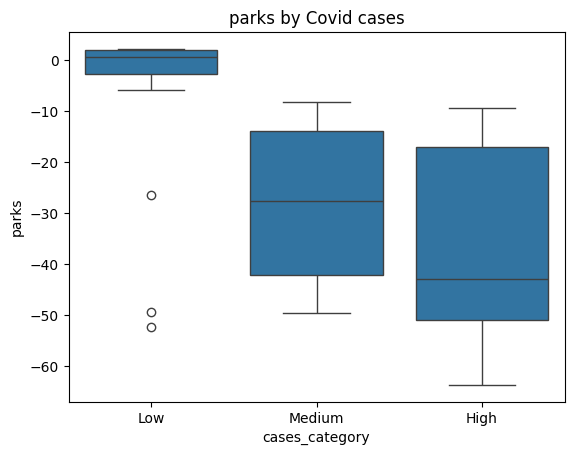

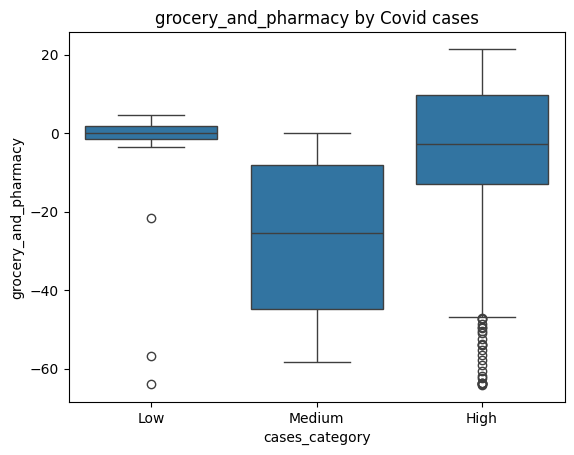

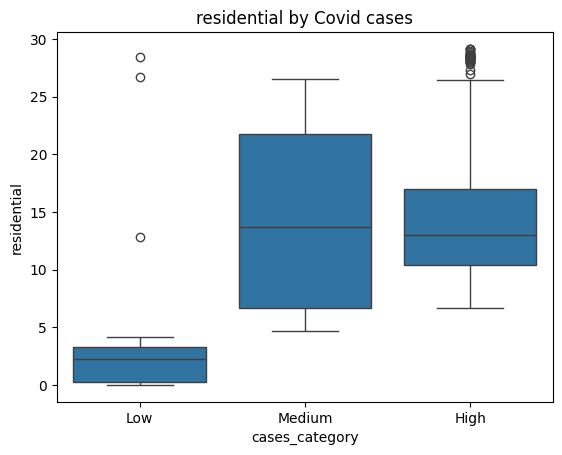

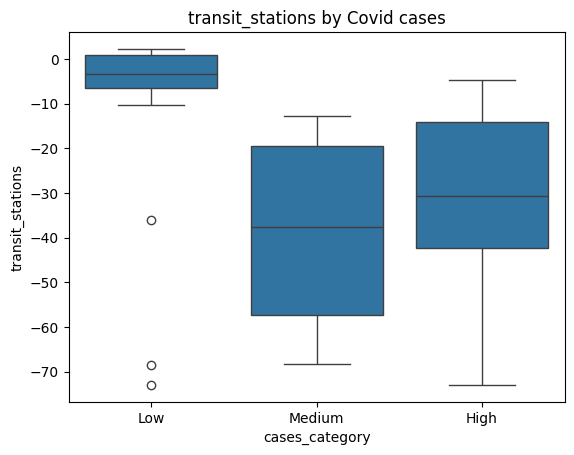

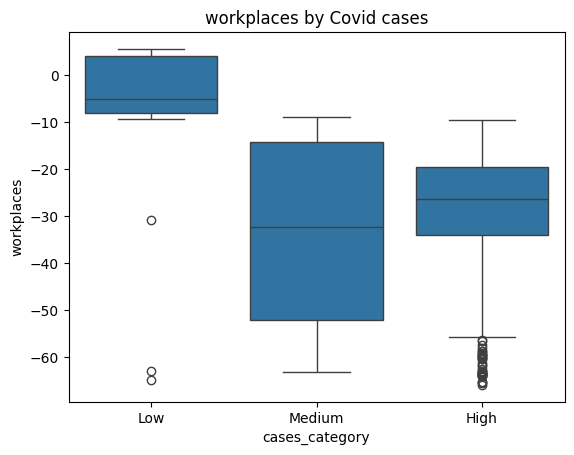

In [23]:
df3['cases_category'] = pd.cut(df3['new_cases'], bins=[0, 50, 100, df3['new_cases'].max()], labels=['Low', 'Medium', 'High'])
mobility_features = ['parks', 'grocery_and_pharmacy', 'residential', 'transit_stations', 'workplaces']
for feature in mobility_features:
    sns.boxplot(data=df3, x='cases_category', y=feature)
    plt.title(f'{feature} by Covid cases')
    plt.show()


It can be observed that outiers exist in mobilities in workplaces and grocery/pharmacy

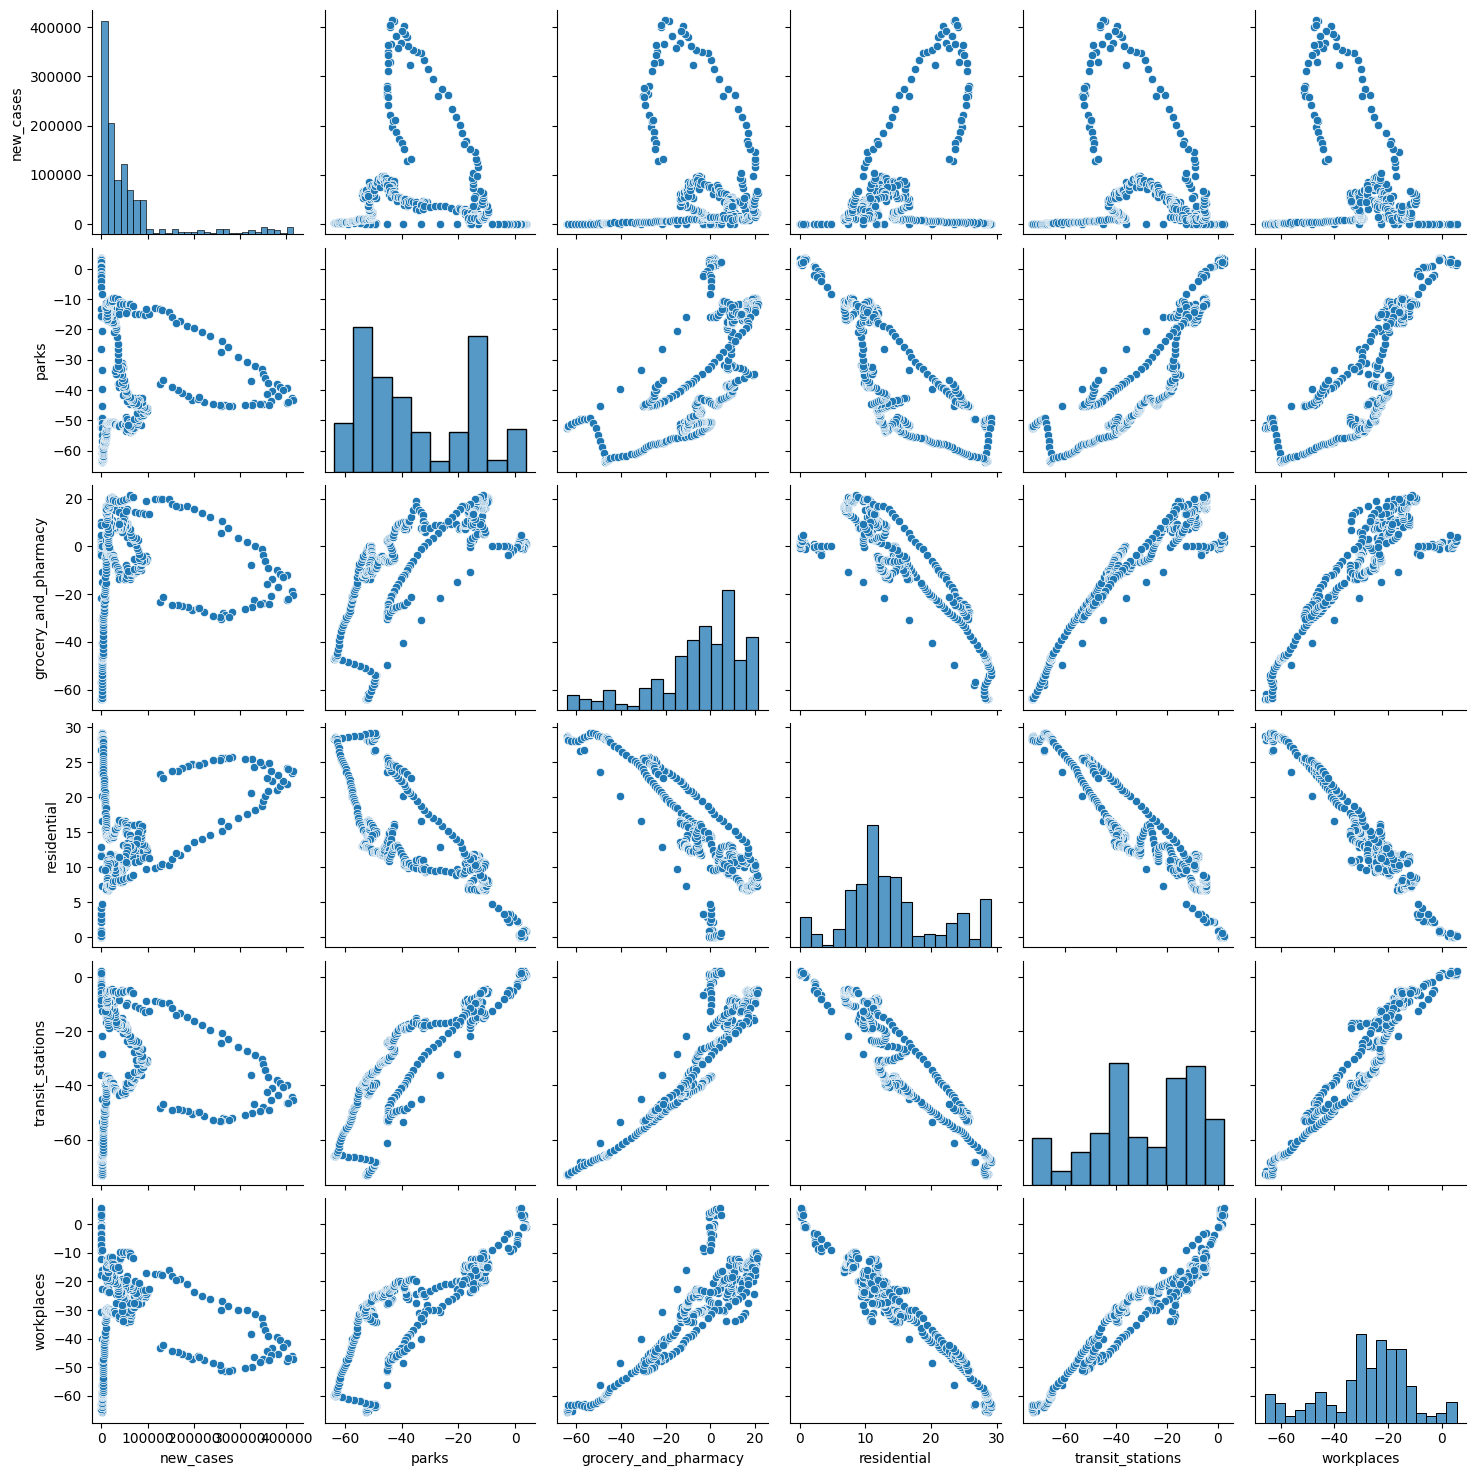

In [24]:
sns.pairplot(df3[['new_cases', 'parks', 'grocery_and_pharmacy', 'residential', 'transit_stations', 'workplaces']])
plt.show()

It can be observed that although the features are seen to have a linear relationship with each other either directly or inversely, there is no linear relationship with the features and the target new cases

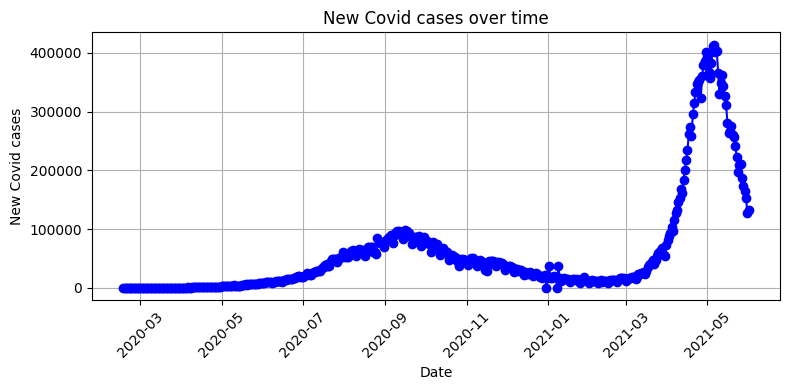

In [25]:
df3['date'] = pd.to_datetime(df3['date'])
plt.figure(figsize=(8, 4))
plt.plot(df3['date'], df3['new_cases'], color='blue', marker='o', linestyle='-')
plt.title('New Covid cases over time')
plt.xlabel('Date')
plt.ylabel('New Covid cases')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

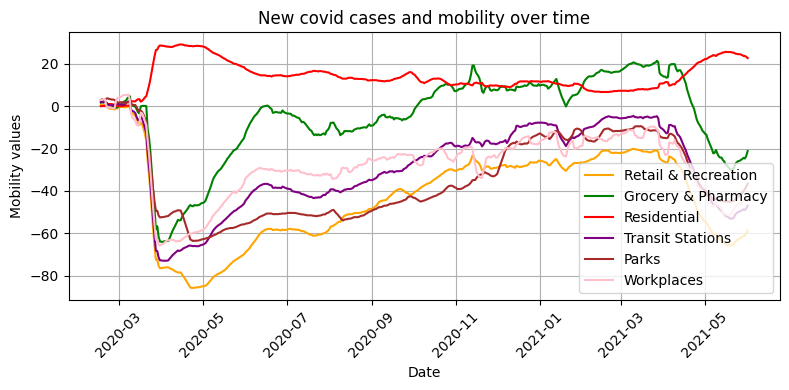

In [26]:
df3['date'] = pd.to_datetime(df3['date'])

plt.figure(figsize=(8, 4))
plt.plot(df3['date'], df3['retail_and_recreation'], color='orange', linestyle='-', label='Retail & Recreation')
plt.plot(df3['date'], df3['grocery_and_pharmacy'], color='green', linestyle='-', label='Grocery & Pharmacy')
plt.plot(df3['date'], df3['residential'], color='red', linestyle='-', label='Residential')
plt.plot(df3['date'], df3['transit_stations'], color='purple', linestyle='-', label='Transit Stations')
plt.plot(df3['date'], df3['parks'], color='brown', linestyle='-', label='Parks')
plt.plot(df3['date'], df3['workplaces'], color='pink', linestyle='-', label='Workplaces')

plt.title('New covid cases and mobility over time')
plt.xlabel('Date')
plt.ylabel('Mobility values')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


##Feature Selection

In [27]:
cm = df3[['retail_and_recreation', 'grocery_and_pharmacy', 'residential', 'transit_stations', 'parks', 'workplaces', 'new_cases']].corr()
cm

,retail_and_recreation,grocery_and_pharmacy,residential,transit_stations,parks,workplaces,new_cases
retail_and_recreation,1.000000,0.820786,-0.925891,0.970580,0.906370,0.928552,-0.134351
grocery_and_pharmacy,0.820786,1.000000,-0.840430,0.913562,0.664009,0.867805,-0.052792
residential,-0.925891,-0.840430,1.000000,-0.928817,-0.768427,-0.969960,0.313037
transit_stations,0.970580,0.913562,-0.928817,1.000000,0.880851,0.951951,-0.153770
parks,0.906370,0.664009,-0.768427,0.880851,1.000000,0.794867,-0.119766
workplaces,0.928552,0.867805,-0.969960,0.951951,0.794867,1.000000,-0.232405
new_cases,-0.134351,-0.052792,0.313037,-0.153770,-0.119766,-0.232405,1.000000


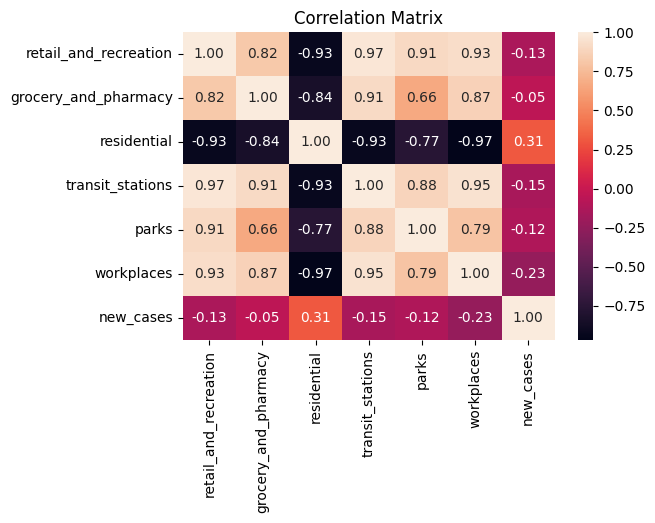

In [28]:
#Visualising the correlation matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True,fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

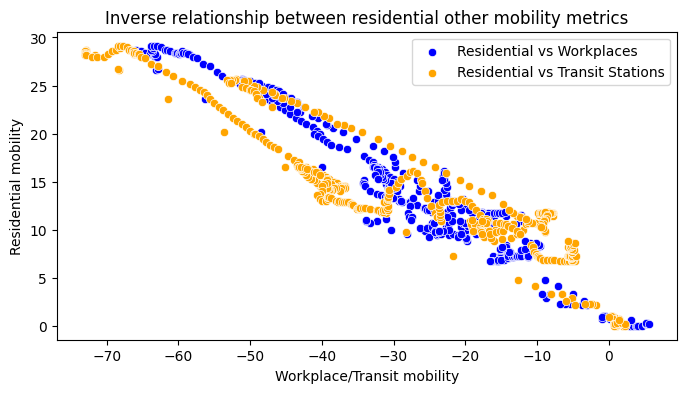

In [29]:
plt.figure(figsize=(8, 4))
sns.scatterplot(x=df3['workplaces'], y=df3['residential'], color="blue", label='Residential vs Workplaces')
sns.scatterplot(x=df3['transit_stations'], y=df3['residential'], color="orange", label='Residential vs Transit Stations')
plt.title('Inverse relationship between residential other mobility metrics')
plt.xlabel('Workplace/Transit mobility')
plt.ylabel('Residential mobility')
plt.legend()
plt.show()

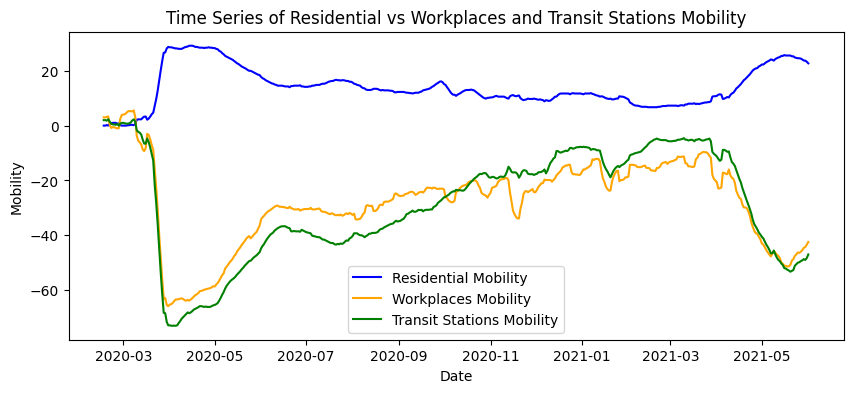

In [30]:
plt.figure(figsize=(10, 4))
plt.plot(df3['date'], df3['residential'], color='blue', label='Residential Mobility')
plt.plot(df3['date'], df3['workplaces'], color='orange', label='Workplaces Mobility')
plt.plot(df3['date'], df3['transit_stations'], color='green', label='Transit Stations Mobility')
plt.xlabel('Date')
plt.ylabel('Mobility')
plt.title('Time Series of Residential vs Workplaces and Transit Stations Mobility')
plt.legend()
plt.show()

It can observed in the above plot that as more people remain in the residential areas, there is less mobility in transit areas and workplaces, signyfying a inverse relationship

In [31]:
upper_tri = cm.where(np.triu(np.ones(cm.shape), k=1).astype(bool))
dropp = [column for column in upper_tri.columns if any(upper_tri[column] >0.95)]
print(dropp)
df3 = df3.drop(columns=dropp)
df3.head()

['transit_stations', 'workplaces']


,iso_code,continent,location,date,new_cases,retail_and_recreation,grocery_and_pharmacy,residential,parks,cases_category
0,IND,Asia,India,2020-02-17,0.0,0.667,1.667,0.000,3.000,NaN
1,IND,Asia,India,2020-02-18,0.0,0.500,1.750,0.000,3.250,NaN
2,IND,Asia,India,2020-02-19,0.0,0.400,1.800,0.200,2.800,NaN
3,IND,Asia,India,2020-02-20,0.0,0.500,2.000,0.000,3.167,NaN
4,IND,Asia,India,2020-02-21,0.0,-0.143,1.714,0.714,3.571,NaN


In [32]:
df3 = df3.drop(['iso_code','continent',	'location',	'date','cases_category'], axis=1)

## Model implementation

CART Algorithm for regression


NOTE: We implemented by finding least RSS( Residual sum of squares) for each feature as threshold.

In [33]:
class Node:
    def __init__(self, feature_index=None, threshold=None, left=None, right=None, var_red=None, value=None):
        self.feature_index = feature_index
        self.threshold = threshold
        self.left = left
        self.right = right
        self.var_red = var_red
        self.value = value

In [34]:
class DecisionTreeRegressor(BaseEstimator, RegressorMixin):
    def __init__(self, min_samples_split=2, max_depth=2):
        self.root = None
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth

    def build_tree(self, dataset, curr_depth=0):
        X, Y = dataset[:, :-1], dataset[:, -1]
        num_samples, num_features = np.shape(X)
        if num_samples >= self.min_samples_split and curr_depth <= self.max_depth:
            best_split = self.get_best_split(dataset, num_samples, num_features)
            if best_split.get("var_red", 0) > 0:
                left_subtree = self.build_tree(best_split["dataset_left"], curr_depth + 1)
                right_subtree = self.build_tree(best_split["dataset_right"], curr_depth + 1)
                return Node(best_split["feature_index"], best_split["threshold"],
                            left_subtree, right_subtree, best_split["var_red"])

        leaf_value = self.calculate_leaf_value(Y)
        return Node(value=leaf_value)

    def get_best_split(self, dataset, num_samples, num_features):
        best_split = {}
        max_var_red = -float("inf")
        for feature_index in range(num_features):
            feature_values = dataset[:, feature_index]
            possible_thresholds = np.unique(feature_values)
            for threshold in possible_thresholds:
                dataset_left, dataset_right = self.split(dataset, feature_index, threshold)
                if len(dataset_left) > 0 and len(dataset_right) > 0:
                    y, left_y, right_y = dataset[:, -1], dataset_left[:, -1], dataset_right[:, -1]
                    curr_var_red = self.calculate_reduction(y, left_y, right_y)
                    if curr_var_red > max_var_red:
                        best_split["feature_index"] = feature_index
                        best_split["threshold"] = threshold
                        best_split["dataset_left"] = dataset_left
                        best_split["dataset_right"] = dataset_right
                        best_split["var_red"] = curr_var_red
                        max_var_red = curr_var_red
        return best_split

    def split(self, dataset, feature_index, threshold):
        dataset_left = np.array([row for row in dataset if row[feature_index] <= threshold])
        dataset_right = np.array([row for row in dataset if row[feature_index] > threshold])
        return dataset_left, dataset_right

    def calculate_reduction(self, parent, l_child, r_child):
        weight_l = len(l_child) / len(parent)
        weight_r = len(r_child) / len(parent)
        reduction = np.var(parent) - (weight_l * np.var(l_child) + weight_r * np.var(r_child))
        return reduction

    def calculate_leaf_value(self, Y):
        return np.mean(Y)

    def fit(self, X, Y):
        dataset = np.concatenate((X, Y), axis=1)
        self.root = self.build_tree(dataset)

    def make_prediction(self, x, tree):
        if tree is None:
            return None
        if tree.value is not None:
            return tree.value
        feature_val = x[tree.feature_index]
        if feature_val <= tree.threshold:
            return self.make_prediction(x, tree.left)
        else:
            return self.make_prediction(x, tree.right)

    def predict(self, X):
        predictions = [self.make_prediction(x, self.root) for x in X]
        return predictions


In [35]:
X = df3.iloc[:, :-1].values
Y = df3.iloc[:, -1].values.reshape(-1,1)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=.2, random_state=42)

In [36]:
regressor = DecisionTreeRegressor(min_samples_split=3, max_depth=3)
regressor.fit(X_train,Y_train)

In [37]:
Y_pred = regressor.predict(X_test)
print("MSE",np.sqrt(mean_squared_error(Y_test, Y_pred)))

r2 = r2_score(Y_test, Y_pred)
print("r2 score:", r2)

MSE 5.064603887777514
r2 score: 0.9369656585394254


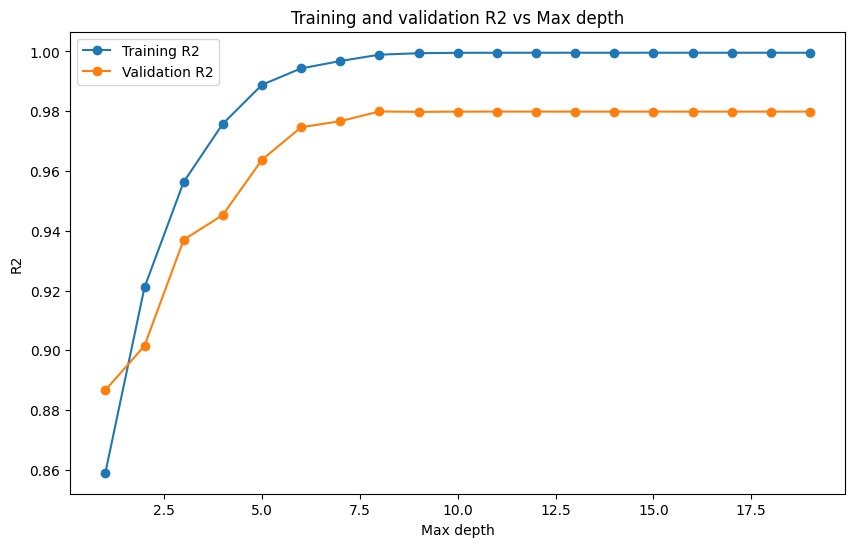

In [38]:
def max_depth_rmse(max_depths):
    model = DecisionTreeRegressor(max_depth=max_depths, min_samples_split=3)
    model.fit(X_train, Y_train)
    train_pred = model.predict(X_train)
    val_pred = model.predict(X_test)
    training_r2 = r2_score(Y_train, train_pred)
    validation_r2 = r2_score(Y_test, val_pred)

    return {"Max depth": max_depths, "Training R2": training_r2, "Validation R2": validation_r2}

max_depth_values = range(1, 20)
results = pd.DataFrame([max_depth_rmse(md) for md in max_depth_values])
plt.figure(figsize=(10, 6))
plt.plot(results["Max depth"], results["Training R2"], label="Training R2", marker="o")
plt.plot(results["Max depth"], results["Validation R2"], label="Validation R2", marker="o")
plt.xlabel("Max depth")
plt.ylabel("R2")
plt.legend()
plt.title("Training and validation R2 vs Max depth")
plt.show()


No significant overfitting observed as the R2 score does not decrease for validation data

## Hyper-parameter tuning using GridSeachCV

In [39]:
df=df3.copy()

In [40]:
X = df.iloc[:, :-1].values
Y = df.iloc[:, -1].values.reshape(-1, 1)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

param_grid = {
    'min_samples_split': [2, 5, 10],
    'max_depth': [2, 3, 4, 5]
}

regressor = DecisionTreeRegressor()
grid_search = GridSearchCV(estimator=regressor, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, Y_train)

best_params = grid_search.best_params_
print("Best Parameters:", best_params)

best_model = grid_search.best_estimator_
Y_pred = best_model.predict(X_test)
rmse = np.sqrt(mean_squared_error(Y_test, Y_pred))
print("RMSE:", rmse)
r2 = r2_score(Y_test, Y_pred)
print("r2 score:", r2)

Best Parameters: {'max_depth': 5, 'min_samples_split': 5}
RMSE: 3.8923981021532343
r2 score: 0.9627676236236732


##Random Forest
For better accuracy, we will implement bagging through ensemble learning

In [41]:
class RandomForestRegressor(BaseEstimator, RegressorMixin):
    def __init__(self, n_estimators=10, min_samples_split=2, max_depth=2, random_state=None):
        self.n_estimators = n_estimators
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        self.trees = []
        self.random_state = random_state
        if random_state:
            np.random.seed(random_state)

    def bootstrap_sample(self, X, Y):
        n_samples = X.shape[0]
        indices = np.random.choice(n_samples, size=n_samples, replace=True)
        return X[indices], Y[indices]

    def fit(self, X, Y):
        for _ in range(self.n_estimators):
            tree = DecisionTreeRegressor(min_samples_split=self.min_samples_split, max_depth=self.max_depth)

            X_sample, Y_sample = self.bootstrap_sample(X, Y)
            dataset = np.concatenate((X_sample, Y_sample), axis=1)
            tree.fit(X_sample, Y_sample)

            self.trees.append(tree)

    def predict(self, X):
        tree_predictions = np.array([tree.predict(X) for tree in self.trees])
        return np.mean(tree_predictions, axis=0)

In [42]:
X = df3.iloc[:, :-1].values
Y = df3.iloc[:, -1].values.reshape(-1, 1)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [43]:
forest = RandomForestRegressor(n_estimators=10, min_samples_split=3, max_depth=3, random_state=42)
forest.fit(X_train, Y_train)

Y_pred = forest.predict(X_test)
rmse = np.sqrt(mean_squared_error(Y_test, Y_pred))
print("RMSE:", rmse)
r2 = r2_score(Y_test, Y_pred)
print("r2 score:", r2)

RMSE: 3.4654676495962558
r2 score: 0.9704872315839063


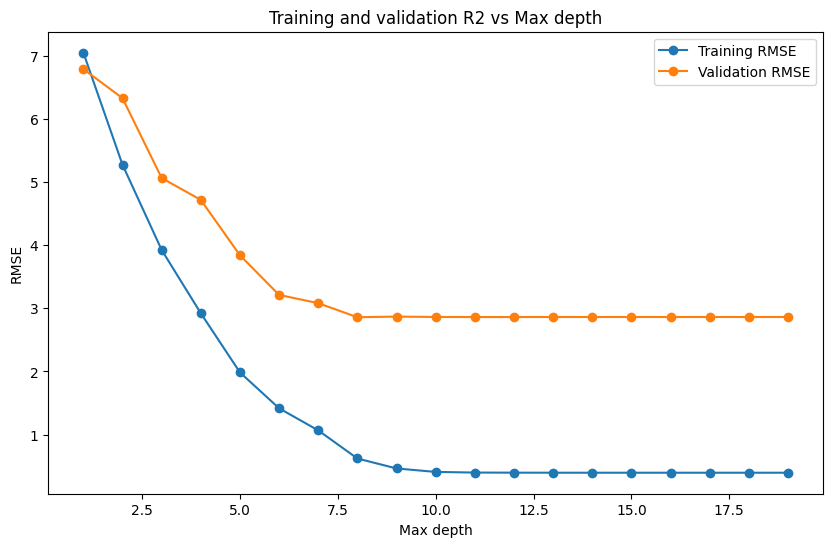

In [44]:
def max_depth_rmse(max_depths):
    model = DecisionTreeRegressor(max_depth=max_depths, min_samples_split=3)
    model.fit(X_train, Y_train)

    train_pred = model.predict(X_train)
    val_pred = model.predict(X_test)

    training_rmse = np.sqrt(mean_squared_error(Y_train, train_pred))
    validation_rmse = np.sqrt(mean_squared_error(Y_test, val_pred))

    return {"Max depth": max_depths, "Training RMSE": training_rmse, "Validation RMSE": validation_rmse}

max_depth_values = range(1, 20)
results = pd.DataFrame([max_depth_rmse(md) for md in max_depth_values])

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(results["Max depth"], results["Training RMSE"], label="Training RMSE", marker="o")
plt.plot(results["Max depth"], results["Validation RMSE"], label="Validation RMSE", marker="o")
plt.xlabel("Max depth")
plt.ylabel("RMSE")
plt.legend()
plt.title("Training and validation R2 vs Max depth")
plt.show()

## Hyper-parameter tuning using GridSeachCV

In [45]:
X = df3.iloc[:, :-1].values
Y = df3.iloc[:, -1].values.reshape(-1, 1)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

param_grid = {
    'n_estimators': [5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'max_depth': [3, 4, 5]
}

forest = RandomForestRegressor()
grid_search = GridSearchCV(estimator=forest, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, Y_train)

best_params = grid_search.best_params_
print("Best Parameters:", best_params)

best_model = grid_search.best_estimator_
Y_pred = best_model.predict(X_test)
rmse = np.sqrt(mean_squared_error(Y_test, Y_pred))
print("RMSE:", rmse)
r2 = r2_score(Y_test, Y_pred)
print("r2 score:", r2)

/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best Parameters: {'max_depth': 5, 'min_samples_split': 2, 'n_estimators': 15}
RMSE: 2.606143844360906
r2 score: 0.9833089746331036


Conclusion: Achieved a R squared score of 0.97 using Random Forest (bagging); Optimised it to 0.983 using GridSearchCV hyperparameter
tuning, outperforming Decision Trees by 5.05%.